# Lower-bounds on the Bayesian Risk in Estimation Procedures via $f$-Divergences: Experiments

The following Python packages are required to run the code:
- NumPy
- SciPy
- Matplotlib

For linux systems, one might need to run the following command to install the required packages to use Latex with matplotlib:

`sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super`

In [1]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt
from scipy.special import gamma, binom, gammaln
from scipy.optimize import minimize

In [2]:
# Style for the plots
plt.style.use('seaborn-whitegrid')
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

# Bernoulli Bias

Here, we have a uniform prior $W \sim U[0,1]$ and samples $X_1, \dots, X_n | W=w$ distributed independently, each according to $\mathrm{Bern}(w)$. In this example, we have $L_W(\rho) \leq g(\rho) = 2\rho$. 

The different bounds we consider involve the following information measures:

- Hellinger Mutual Information of order p
- $E_{\beta, \gamma}$-Mutual Information
- Shannon's Mutual Information
- Maximal Leakage

Note that all bounds considered in this example except the one with Shannon's Mutual Information take the form $\sup_{\rho>0}\rho(1-c\rho^t - b)$, with $c, b, t \geq 0$. In such a case, it can be shown that the maximum is attained at $\rho^\star = \left(\frac{1-b}{(t+1)c}\right)^{\frac1t}$, which is used repeatedly in the code below. 

## Some useful helper functions

In [3]:
def optimal_rho(c, t, b):
    """Returns the value of rho which maximizes the formula rho*(1-c*rho^t-b)"""
    return np.power((1-b) / (c*(t+1)), 1 / t)

def optimal_rho_lower_bound(c, t, b):
    """Returns the best lower bound value for bounds of the form rho*(1-c*rho^t-b)"""
    rho = optimal_rho(c, t, b)
    return np.maximum(0, rho * (1 - c * np.power(rho, t) - b))

def maximize_s(p):
    """Returns the result of maximizing over s the function s*(1-s)^p."""
    optimal_s = 1 / (p+1)
    return optimal_s * np.power(1-optimal_s, p)

def log_comb(n, k):
    """Computes the log of the Binomial Coefficient (good for large values of n and k)"""
    return (gammaln(n+1) - gammaln(n-k+1) - gammaln(k+1))

def n_th_harmonic_number(n):
    """Computes the n^th harmonic number"""
    if n == 0:
        return 0
    number = 0
    for i in range(1, n+1):
        number += 1 / i
    return number

## Lower Bounds

### Hellinger Mutual Information

Here, the bound takes the form 

$$\sup_{\rho > 0} \rho\left(1-(2\rho)^{\frac{p-1}{p}}\left((p-1)\mathcal{H}_p(W,X^n)+1\right)^{\frac1p}\right),$$

with $p>1$. Note that it can be re-written as $\sup_{\rho>0}\rho(1-c\rho^t - b)$ with $t=\frac{p-1}{p}, c=(2)^{\frac{p-1}{p}}\left((p-1)\mathcal{H}_p(W,X^n)+1\right)^{\frac1p}$ and $b=0$.

In fact in the paper, we show that when using $p=2$, we retrieve
$$R \geq \frac{7}{72\sqrt{\pi n}}.$$

In [4]:
def compute_term_hellinger(n, k, p):
    """Computes a term in the sum involved in the computation of the Hellinger MI"""
    log_term = p*log_comb(n, k) + gammaln(k*p+1) + gammaln(n*p-k*p + 1) - gammaln(n*p+2)
    return np.exp(log_term)
    
def compute_hellinger(n, p):
    """Computes the entire sum for Hellinger p"""
    init = 0
    for k in range(n+1):
        init += compute_term_hellinger(n, k, p)
    return (np.power(n+1, p-1)*init-1)/(p-1)

def hellinger_bound_bernoulli(n, p, private=False, epsilon=0.0, delta=0.0):
    """Hellinger lower bound when maximizing over rho > 0.
    If the `private` parameter is set to True along with `epsilon` and `delta`, the LDP coefficient
    is added in the formula."""
    hellinger_mi = compute_hellinger(n, p)
    if private:
        hellinger_mi *= ldp_contraction(n, epsilon, delta)
        
    t = (p-1) / p
    c = np.power(2, t) * np.power((p-1) * hellinger_mi+1, 1 / p)
    b = 0
    return optimal_rho_lower_bound(c, t, b)

### $E_{\beta, \gamma}$- Mutual Information

Here, the bound takes the form 

$$\sup_{\rho > 0} \rho\left(1-\frac{E_{\gamma}(W,X^n)-2\rho\gamma}{\beta}\right),$$

with $\beta>0$ and $\gamma\geq\beta$. Note that it can be re-written as $\sup_{\rho>0}\rho(1-c\rho^t - b)$ with $t=1, c=\frac{2\gamma}{\beta}$ and $b=\frac{E_{\gamma}(W,X^n)}{\beta}$.

> ⚠️ The computing time might be long as this involves the computation of an integral with SciPy!

In [5]:
def e_beta_gamma(n, gamma, beta):
    """Computes the Beta-Gamma Mutual Information in the Bernoulli samples example."""
    def to_integrate(w, n, k, gamma):
        return np.maximum(0, beta*(n+1)*np.exp(log_comb(n, k) + k*np.log(w) + (n-k)*np.log(1-w)) -gamma)
    
    init = 0 
    for k in range(n+1):
        init += scipy.integrate.quad(lambda w: to_integrate(w, n, k, gamma), a=0, b=1)[0]
    return init / (n+1)  

def e_beta_gamma_bound_bernoulli(n, gamma, beta, private=False, epsilon=0.0, delta=0.0):
    """Beta-Gamma Mutual Information lower bound when maximizing over rho > 0.
    If the `private` parameter is set to True along with `epsilon` and `delta`, the LDP coefficient
    is added in the formula."""
    if gamma < beta:
        raise ValueError('The E_{beta, gamma} bound requires gamma >= beta')
    b = e_beta_gamma(n, gamma, beta) / beta
    if private:
        b *= ldp_contraction(n, epsilon, delta)
    c = 2 * gamma / beta
    t = 1
    return optimal_rho_lower_bound(c, t, b)

### Shannon's Mutual Information

Following Theorem 1 in https://arxiv.org/pdf/1607.00550.pdf, the bound takes the form
$$\sup_{\rho > 0} \rho\left(1-\frac{I(W;X^n) + \log(2)}{\log(1/L_W(\rho))}\right)$$.

In this case, the optimal value of $\rho$ is slightly different from other bounds and is equal to $\rho^\star = \frac{1}{2}\exp\left(\frac{1}{2}(-r-\sqrt{r(r+4)})\right)$ where $r=I(W;X^n) + \log(2)$.

In fact in Corollary 2 in https://arxiv.org/pdf/1607.00550.pdf, the bound given for the Bernoulli Bias example is
$$R \gtrsim \frac{1}{16\sqrt{2\pi n}}.$$ 

In [6]:
def compute_mutual_information(n):
    """Computes the Mutual Information"""
    init = 0
    for k in range(n+1):
        init += np.log(n+1) + log_comb(n, k) + k * n_th_harmonic_number(k) + (n-k)*n_th_harmonic_number(n-k)-n*n_th_harmonic_number(n+1)
    return (1 / (n+1)) * init

def mutual_information_bound_bernoulli(n, private=False, epsilon=0.0, delta=0.0):
    """Computes the Mutual Information lower-bound with optimization over rho>0.
    If the `private` parameter is set to True along with `epsilon` and `delta`, the LDP coefficient
    is added in the formula."""
    mutual_information = compute_mutual_information(n)
    if private:
        mutual_information *= ldp_contraction(n, epsilon, delta)
    mi_plus_log = mutual_information + np.log(2)
    optimal_rho = 0.5*np.exp(0.5*(-mi_plus_log-np.sqrt(mi_plus_log*(mi_plus_log+4))))
    return np.maximum(0, optimal_rho*(1- mi_plus_log / np.log(1 / (2*optimal_rho))))

### Maximum Leakage

This follows from Corollary 1 in https://ieeexplore.ieee.org/document/9517954, and is essentially equal to previous bound for $\alpha \to +\infty$. It then takes the form 

$$\sup_{\rho > 0} \rho\left(1-2\rho\exp\left(\mathcal{L}(W\to X^n)\right)\right).$$

Note that it can be re-written as $\sup_{\rho>0}\rho(1-c\rho^t - b)$ with $t=1, c=2\exp\left(\mathcal{L}(W\to X^n)\right)$ and $b=0$.

In fact in https://ieeexplore.ieee.org/document/9517954 (Equation 16), the bound given for the Bernoulli Bias example is
$$R \geq \frac{1}{8\left(2+\sqrt{\frac{\pi n}{2}}\right)},$$ 

but is looser due to the fact that the Maximal Leakage was upper-bounded instead of being computed exactly.

In [7]:
def exp_max_leakage(n):
    """Computes the value of exp(L)."""
    init = 0
    for k in range(n+1):
        if k==0 or k==n:
            init += 1
        else:
            init += np.exp(log_comb(n, k) + k*np.log(k/n) + (n-k)*np.log(1-k/n))
    return init

def max_leakage_bound_bernoulli(n):
    """Maximal Leakage lower bound when maximizing over rho > 0."""
    t = 1
    c = 2 * exp_max_leakage(n)
    return optimal_rho_lower_bound(c, t, b=0)

## Comparison of the Bounds

Here we compare the values of the different bounds as a function of the number of samples $n$ (ranging from 1 to 50).

In [8]:
x_axis = range(1, 51)

### Best bound for fixed $n$

For bounds which involve an extra parameter ($\beta, \gamma$ or $p$), we use for each $n$ the value of the parameter which maximizes the bound.

#### With exact computation of information measures

In [10]:
lb_hellinger_bernoulli = []
lb_beta_gamma_bernoulli = []
lb_max_leakage_bernoulli = []
lb_mutual_information_bernoulli = []
upper_bound_bernoulli = []

for n in x_axis:
    lb_hellinger_bernoulli.append(-minimize(lambda p: -hellinger_bound_bernoulli(n, p), x0=[7.0], tol=1e-10, bounds=[(1.001, None)]).fun[0])
    lb_max_leakage_bernoulli.append(max_leakage_bound_bernoulli(n))
    
    # First optimize over gamma for beta fixed at 1, and then optimize over beta
    optimal_gamma = minimize(lambda gamma: -e_beta_gamma_bound_bernoulli(n, gamma, 1), x0=4.0, tol=1e-10, bounds=[(1, None)]).x[0]
    lb_beta_gamma_bernoulli.append(-minimize(lambda beta: -e_beta_gamma_bound_bernoulli(n, optimal_gamma, beta), x0=1.0, tol=1e-10, bounds=[(0.001, optimal_gamma)]).fun[0])
    
    lb_mutual_information_bernoulli.append(mutual_information_bound_bernoulli(n))
    upper_bound_bernoulli.append(1/np.sqrt(6*n))

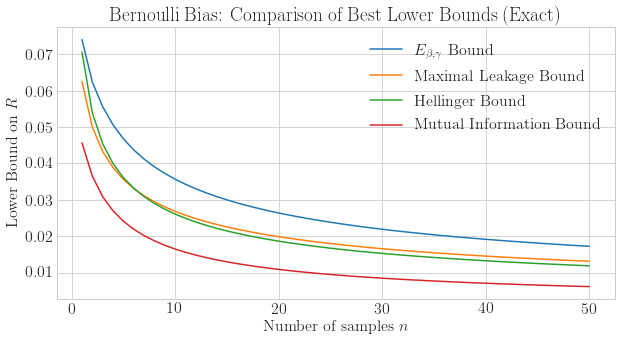

In [11]:
x_axis = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, lb_beta_gamma_bernoulli, label=rf'$E_{{\beta,\gamma}}$ Bound')
plt.plot(x_axis, lb_max_leakage_bernoulli, label=r"Maximal Leakage Bound")
plt.plot(x_axis, lb_hellinger_bernoulli, label=fr'Hellinger Bound')
plt.plot(x_axis, lb_mutual_information_bernoulli, label=r"Mutual Information Bound")
#plt.plot(upper_bound, label='Upper Bound')
plt.xlabel(r'Number of samples $n$')
plt.ylabel(r'Lower Bound on $R$')
plt.title(r'Bernoulli Bias: Comparison of Best Lower Bounds (Exact)')
plt.legend()
plt.show()

#### Without exact computation of information measures

> Please run previous cells of this example before running this one

We compute the lower-bounds for Maximal Leakage and Shannon's MI as given in the corresponding papers.

In [12]:
lb_max_leakage_bernoulli = []
lb_mutual_information_bernoulli = []

for n in x_axis:
    lb_max_leakage_bernoulli.append(1/(8*(2+np.sqrt(np.pi*n))))
    lb_mutual_information_bernoulli.append(1/(16*np.sqrt(2*np.pi*n)))

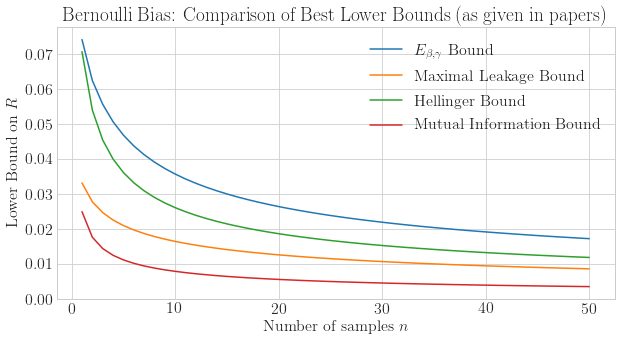

In [13]:
x_axis = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, lb_beta_gamma_bernoulli, label=rf'$E_{{\beta,\gamma}}$ Bound')
plt.plot(x_axis, lb_max_leakage_bernoulli, label=r"Maximal Leakage Bound")
plt.plot(x_axis, lb_hellinger_bernoulli, label=fr'Hellinger Bound')
plt.plot(x_axis, lb_mutual_information_bernoulli, label=r"Mutual Information Bound")
#plt.plot(upper_bound, label='Upper Bound')
plt.xlabel(r'Number of samples $n$')
plt.ylabel(r'Lower Bound on $R$')
plt.title(r'Bernoulli Bias: Comparison of Best Lower Bounds (as given in papers)')
plt.legend()
plt.show()

### Bounds for specific choices of parameters and fixed $n$

> Please run previous cells of this example before running this one

Here we show the bounds when parameters are set to $p=2$, $\gamma=2.2$ and $\beta=0.75$. For the Hellinger bound with $p=2$, we actually depict the bound derived in Corollary 3 in the paper.

In [15]:
p = 2
gamma = 2.2
beta = 0.75

lb_hellinger_bernoulli = []
lb_beta_gamma_bernoulli = []

for n in x_axis:
    #lb_hellinger_bernoulli.append(hellinger_bound(n, p))
    lb_hellinger_bernoulli.append((7/72)/np.sqrt(np.pi*n))
    lb_beta_gamma_bernoulli.append(e_beta_gamma_bound_bernoulli(n, gamma, beta))

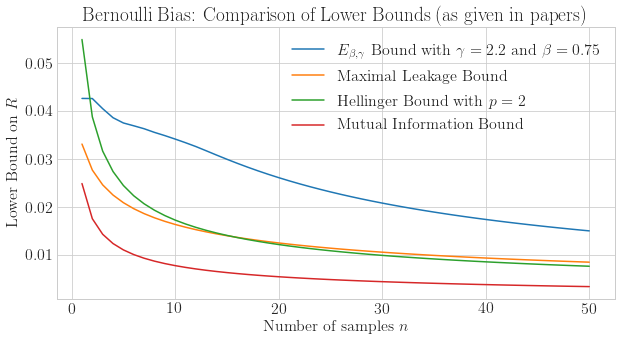

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(x_axis, lb_beta_gamma_bernoulli, label=rf'$E_{{\beta,\gamma}}$ Bound with $\gamma={gamma}$ and $\beta={beta}$')
plt.plot(x_axis, lb_max_leakage_bernoulli, label=r"Maximal Leakage Bound")
plt.plot(x_axis, lb_hellinger_bernoulli, label=fr'Hellinger Bound with $p={p}$')
plt.plot(x_axis, lb_mutual_information_bernoulli, label=r"Mutual Information Bound")
#plt.plot(upper_bound, label='Upper Bound')
plt.xlabel(r'Number of samples $n$')
plt.ylabel('Lower Bound on $R$')
plt.title(r'Bernoulli Bias: Comparison of Lower Bounds (as given in papers)')
plt.legend()
plt.show()

# Gaussian Location Model

Here, we have a uniform prior $W \sim \mathcal{N}(0, \sigma_W^2I_d)$ and samples $X_1, \dots, X_n | W=w$ distributed independently, each according to $\mathcal{N}(w, \sigma^2I_d)$.

The different bounds we consider involve the following information measures:

- Hellinger Mutual Information of order $p$
- $E_{\beta, \gamma}$- Mutual Information
- Shannon's Mutual Information
- Sibson's $\alpha$-Mutual Information

*Note*: The Maximal Leakage bound is not included simply because of the fact that since the support of $W$ is infinite, the maximal leakage also becomes infinite.

Here, we sometimes include the lower-bounds using the technique described in the paper's appendix, so that we end up with a maximization over $s \in (0, 1)$ involving an increasing function $g(\rho)$ which upper-bounds the small-ball probability $L_W(\rho)$. In this example, we have $L_W(\rho) \leq g(\rho) = \left(\frac{\rho}{\sqrt{2\pi\sigma_W^2}}\right)^dV_d$, where $V_d$ denotes the volume of the unit $\ell_1$-ball. 

*Note*: In the paper, we consider only the setting when $d=1$. Here, we provide numerical computations for the general case in $d$ dimensions. Below, we write code to compute $V_d^{1/d}$, together with code to compute the Gaussian probability density function, which are useful in next computations.

In [17]:
def l1_ball_computation(d):
    """Computes the volume of the l1-ball of dimension d, raised to the power 1/d."""
    return np.exp(np.log(2) - gammaln(d+1)/d)

def gaussian_pdf(x, mean, var):
    """Computes the Gaussian PDF for a Gaussian random variable with given mean and variance."""
    return (1 / np.sqrt(2 * np.pi * var))* np.exp(-np.power(x-mean, 2) / (2 * var))

### Hellinger Mutual Information

Here, the bound with the reparametrization over $s \in (0,1)$ takes the form 
$$\sup_{s \in (0, 1)} \frac{\sqrt{2\pi\sigma_W^2}s}{V_d^{1/d}}\left(\frac{(1-s)^p}{(p-1)\mathcal{H}_p(W;X^n)+1}\right)^{\frac{1}{d(p-1)}},$$
with $p>1$. Moreover, one can show that $(p-1)\mathcal{H}_p(W;X^n)+1 = \left(\frac{\left(1+n\frac{\sigma_W^2}{\sigma^2}\right)^p}{1 + (2-p)pn\frac{\sigma_W^2}{\sigma^2}} \right)^{\frac{d}{2}}$.

In fact, we show in the paper that one can retrieve the following lower-bound on the risk:
$$R \geq \frac{81\sqrt{2\pi}}{2048}\sqrt{\frac{\sigma_W^2}{1+n\frac{\sigma_W^2}{\sigma^2}}}.$$

In [18]:
def hellinger_bound_gaussian(n, p, sigma_w_squared, sigma_squared, d):
    return (1/l1_ball_computation(d))*np.sqrt(2*np.pi*sigma_w_squared)*maximize_s(p/(d*(p-1)))* np.power(1+(2-p)*p*n*sigma_w_squared/sigma_squared, 1/(2*(p-1))) / np.power(1+n*sigma_w_squared/sigma_squared, p/(2*(p-1)))

### $E_{\beta, \gamma}$- Mutual Information

Here, the bound with the parametrization over $\rho > 0$ takes the form 
$$\sup_{\rho > 0} \rho\left(1-\frac{E_{\beta,\gamma}(W, X^n)}{\beta} - \frac{\gamma}{\beta}\left(\frac{\rho}{\sqrt{2\pi\sigma_W^2}}\right)^dV_d\right),$$
with $\beta > 0$ and $\gamma\geq\beta$.

> ⚠️ The computation of $E_{\beta, \gamma}(W, X^n)$ here is only provided for the case $d=1$ since the computation becomes too demanding otherwise. Note that the computation of the integral takes long to compute already when $d=1$.

In [19]:
def e_beta_gamma(n, gamma, beta, sigma_w_squared, sigma_squared):
    """Computes the E_gamma mutual information for the Gaussian example."""
    def to_integrate(x, w, n, gamma):
        return gaussian_pdf(w, 0, sigma_w_squared) * np.abs(beta * gaussian_pdf(x, w, sigma_squared/n) - gamma * gaussian_pdf(x, 0, sigma_w_squared+sigma_squared/n))
    integral = scipy.integrate.dblquad(lambda x, w: to_integrate(x, w, n, gamma), -25, 25, lambda x: -25, lambda x: 25)
    return 0.5 * (integral[0] - (gamma-beta))

def e_beta_gamma_bound_gaussian(n, gamma, beta, sigma_w_squared, sigma_squared):
    """Computes the E_gamma bound for the Gaussian example."""
    c = 2*gamma / (np.sqrt(2*np.pi*sigma_w_squared)*beta)
    b = e_beta_gamma(n, gamma, beta, sigma_w_squared, sigma_squared) / beta
    return optimal_rho_lower_bound(c, 1, b)

### Shannon's Mutual Information

Here, the bound takes the form 
$$\sup_{s \in (0, 1)} \frac{\sqrt{2\pi\sigma_W^2}s}{V_d^{1/d}}\exp\left(-\frac{I(W;X^n) + \log(2)}{1-s}\right).$$
Moreover, one can show that $I(W;X^n) = \frac{d}{2}\log\left(1+n\frac{\sigma_W^2}{\sigma^2}\right)$.

In fact, it is shown in Corollary 1 in https://arxiv.org/pdf/1607.00550.pdf that one has

$$R \geq \frac{\sqrt{\pi}}{16\sqrt{2}}\sqrt{\frac{\sigma_W^2}{1+n\frac{\sigma_W^2}{\sigma^2}}}.$$

In [20]:
def mutual_information_bound_gaussian(n, sigma_w_squared, sigma_squared, d):
    mutual_information = (d/2)*np.log(1 + n*sigma_w_squared/sigma_squared) + np.log(2)
    optimal_s = 1 + 0.5 * (mutual_information-np.sqrt(mutual_information*(mutual_information+4)))
    return (1/l1_ball_computation(d))*np.sqrt(2*np.pi*d*sigma_w_squared)*optimal_s*np.exp(-(1/d)*mutual_information / (1-optimal_s))

### Sibson's Mutual Information

Here, the bound takes the form 
$$\sup_{s \in (0, 1)} \frac{\sqrt{2\pi\sigma_W^2}s}{V_d^{1/d}}\left(\frac{(1-s)^\frac{\alpha}{\alpha-1}}{\exp(I_{\alpha}(W;X^n))}\right),$$
with $\alpha>1$. Moreover, one can show that $I_{\alpha}(W;X^n) = \frac{d}{2}\log\left(1+n\alpha\frac{\sigma_W^2}{\sigma^2}\right)$.

In fact, it is shown in https://ieeexplore.ieee.org/document/9517954 (Equation 21) that one has

$$R \geq \frac{\sqrt{\pi}}{2^{7/2}}\sqrt{\frac{\sigma_W^2}{1+2n\frac{\sigma_W^2}{\sigma^2}}}.$$

In [21]:
def I_alpha_bound_gaussian(n, alpha, sigma_w_squared, sigma_squared, d):
    return (1/l1_ball_computation(d))*np.sqrt(2*np.pi*sigma_w_squared)*maximize_s(alpha/(d*(alpha-1))) * (1/np.sqrt(1 + alpha*n*sigma_w_squared/sigma_squared))

## Comparison of the Bounds

Here we compare the values of the different bounds as a function of the number of samples $n$ (ranging from 1 to 50) for the case $d=1$, $\sigma_W^2=1$ and $\sigma^2=2$.

In [36]:
x_axis = range(1, 51)
d = 1
sigma_squared = 2
sigma_w_squared = 1

### Best bound for fixed $n$

For bounds which involve an extra parameter ($\alpha, \gamma$ or $p$), we use for each $n$ the value of the parameter which maximizes the bound.

> Note that since the $E_{\beta, \gamma}$ is already demanding to compute, we set $\beta=1$ and only optimize over $\gamma\geq1$.

Here, all bounds are computed **exactly**.

In [42]:
lb_I_alpha_gaussian = []
lb_hellinger_gaussian = []
lb_mutual_information_gaussian = []
lb_gamma_gaussian = []
upper_bound_gaussian = []

for n in x_axis:
    # Find best alpha parameter for I alpha bound
    i_alpha_optimization_result = minimize(lambda a: -I_alpha_bound_gaussian(n, a, sigma_w_squared, sigma_squared, d), x0=2., tol=1e-15, bounds=[(1.001, None)])
    lb_I_alpha_gaussian.append(-i_alpha_optimization_result.fun[0])
    
    # Find best p parameter for Hellinger bound
    hellinger_optimization_result = minimize(lambda p: -hellinger_bound_gaussian(n, p, sigma_w_squared, sigma_squared, d), x0=2., tol=1e-15, bounds=[(1.001, 2)])
    lb_hellinger_gaussian.append(-hellinger_optimization_result.fun[0])
        
    # Compute the lower bound using E_gamma (that is using beta=1)
    gamma_optimization_result = minimize(lambda gamma: -e_beta_gamma_bound_gaussian(n, gamma, 1, sigma_w_squared, sigma_squared), x0=2.5, tol=1e-5, bounds=[(1, 5.5)])
    lb_gamma_gaussian.append(-gamma_optimization_result.fun[0])
    
    # Compute lower bound using Mutual Information§1§
    lb_mutual_information_gaussian.append(mutual_information_bound_gaussian(n, sigma_w_squared, sigma_squared, d))
    
    # Compute the value of the upper-bound
    upper_bound_gaussian.append(np.sqrt(d*sigma_w_squared/(1 +n*sigma_w_squared/sigma_squared)))

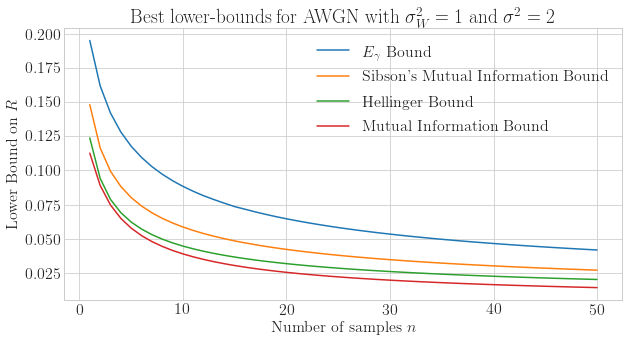

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(x_axis, lb_gamma_gaussian, label=rf'$E_\gamma$ Bound')
plt.plot(x_axis, lb_I_alpha_gaussian, label=rf"Sibson's Mutual Information Bound")
plt.plot(x_axis, lb_hellinger_gaussian, label=rf'Hellinger Bound')
plt.plot(x_axis, lb_mutual_information_gaussian, label=rf'Mutual Information Bound')
#plt.plot(x_axis, upper_bound, label=r'Upper Bound')
plt.xlabel('Number of samples $n$')
plt.ylabel('Lower Bound on $R$')
plt.legend()
plt.title(rf'Best lower-bounds for AWGN with $\sigma_W^2={sigma_w_squared}$ and $\sigma^2={sigma_squared}$')
plt.show()

### Bound for specific parameters and fixed $n$

#### With exact computation of information measures

> Please run previous cells of this example before running this one

We compute the lower-bounds exactly using $p=3/2$, $\alpha = 2$, $\beta=0.75$, and $\gamma=2.2$.

In [44]:
p = 3/2
alpha = 2
gamma = 2.2
beta=0.75

lb_I_alpha_gaussian = []
lb_hellinger_gaussian = []
lb_gamma_gaussian = []

for n in x_axis:
    # Compute the lower bound using I alpha
    lb_I_alpha_gaussian.append(I_alpha_bound_gaussian(n, alpha, sigma_w_squared, sigma_squared, d))

    # Compute the lower bound using Hellinger
    lb_hellinger_gaussian.append(hellinger_bound_gaussian(n, p, sigma_w_squared, sigma_squared, d))

    # Compute the lower bound using E_gamma
    lb_gamma_gaussian.append(e_beta_gamma_bound_gaussian(n, gamma, beta, sigma_w_squared, sigma_squared))

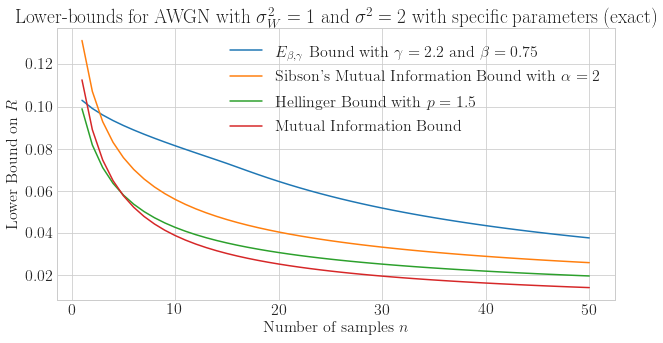

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(x_axis, lb_gamma_gaussian, label=rf'$E_{{\beta,\gamma}}$ Bound with $\gamma={gamma}$ and $\beta={beta}$')
plt.plot(x_axis, lb_I_alpha_gaussian, label=rf"Sibson's Mutual Information Bound with $\alpha={alpha}$")
plt.plot(x_axis, lb_hellinger_gaussian, label=rf'Hellinger Bound with $p={p}$')
plt.plot(x_axis, lb_mutual_information_gaussian, label=rf'Mutual Information Bound')
#plt.plot(x_axis, upper_bound, label=r'Upper Bound')
plt.xlabel('Number of samples $n$')
plt.ylabel('Lower Bound on $R$')
plt.legend()
plt.title(rf'Lower-bounds for AWGN with $\sigma_W^2={sigma_w_squared}$ and $\sigma^2={sigma_squared}$ with specific parameters (exact)')
plt.show()

#### Without exact computation of information measures

> Please run previous cells of this example before running this one

Here we compare bounds as they are given in the various papers, that is:
- The $E_{\beta, \gamma}$ bound the one given in Equation 42 in our paper and is computed numerically.
- The Hellinger bound is the one given in Corollary 3 in our paper.
- The Shannon's Mutual Information bound is the one given in Corollary 1 in https://arxiv.org/pdf/1607.00550.pdf.
- The Sibson's Mutual Information bound is the one given in Equation 21 in https://ieeexplore.ieee.org/document/9517954.

In [46]:
lb_I_alpha_gaussian = []
lb_hellinger_gaussian = []
lb_mutual_information_gaussian = []

for n in x_axis:
    # Compute lower-bound with Sibson's Mutual Information as given in the corresponding paper
    lb_I_alpha_gaussian.append(np.power(1/2, 7/2)*np.sqrt(np.pi)*np.sqrt(sigma_w_squared/(1+2*n*sigma_w_squared/sigma_squared)))
    
    # Compute lower-bound with Hellinger divergence as given in our paper
    lb_hellinger_gaussian.append((81/2048)*np.sqrt(2*np.pi)*np.sqrt(sigma_w_squared/(1+n*sigma_w_squared/sigma_squared)))
        
    # Compute lower-bound with Shannon's Mutual Information as given in the corresponding paper
    lb_mutual_information_gaussian.append((1/16)*np.sqrt(np.pi/2)*np.sqrt(sigma_w_squared/(1+n*sigma_w_squared/sigma_squared)))

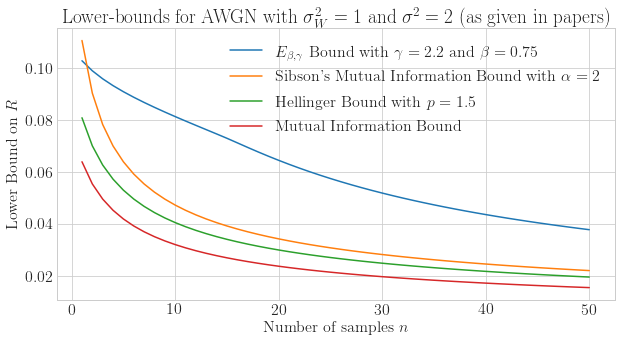

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(x_axis, lb_gamma_gaussian, label=rf'$E_{{\beta,\gamma}}$ Bound with $\gamma={gamma}$ and $\beta={beta}$')
plt.plot(x_axis, lb_I_alpha_gaussian, label=rf"Sibson's Mutual Information Bound with $\alpha={alpha}$")
plt.plot(x_axis, lb_hellinger_gaussian, label=rf'Hellinger Bound with $p={p}$')
plt.plot(x_axis, lb_mutual_information_gaussian, label=rf'Mutual Information Bound')
#plt.plot(x_axis, upper_bound, label=r'Upper Bound')
plt.xlabel('Number of samples $n$')
plt.ylabel('Lower Bound on $R$')
plt.legend()
plt.title(rf'Lower-bounds for AWGN with $\sigma_W^2={sigma_w_squared}$ and $\sigma^2={sigma_squared}$ (as given in papers)')
plt.show()